<a href="https://colab.research.google.com/github/ericbill21/siemens/blob/BobsLaboratory/Siemens_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#@title Imports and config

# Tensorflow and Keras
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
from psutil import virtual_memory

# Arithmetic Operations
import pandas as pd
import numpy as np
import random
import math

# Data visualization
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('default')

# Progress calculation
import sys
import logging
import time
from datetime import date

# time prediciton
PREV_TIME = 0
PB_START_TIME = 0

In [2]:
#@title Global constants

# Dictionaries
COLORS = {0 : 'green', 1 : 'red', 'green' : 0, 'red' : 1}
SOURCES = {'A' : 'https://drive.google.com/file/d/1hAzAKZNpmSclSI7HnV_cRjpMS4Kh5r1q/view?usp=sharing', 'B' : 'https://drive.google.com/file/d/12VlecL-5iYs-BFpnTOba1x65jWofBX1P/view?usp=sharing', 'C' : 'https://drive.google.com/file/d/1-Z0RuJIi1cZcqrrmV6TqT0O1PwI2OiBY/view?usp=sharing'}
SOURCE_SIZE = {'A': 1000,'B' : 5000, 'C' : 50000}

CURRENT_SET = 'A'

# Balancing dataset to threshold
THRESHOLD = 0.4

# Random number seed
random.seed(time.time())

# Examlpe subsets of each dataset
#subsetA = [47, 847, 993, 55, 102, 572, 430, 115, 842, 72, 770, 107, 78, 834, 593, 43, 234, 709, 210, 378]
#subsetB = [606, 2663, 1809, 2145, 4539, 3333, 3562, 2262, 512, 2046, 1541, 909, 286, 4815, 3663, 1742, 2822, 2756, 2937, 3080, 3845, 3949, 2506, 3984, 2803, 2067]
#subsetC = [32088, 33534, 39634, 40177, 25142, 752, 41771, 11793, 16415, 3811, 2096, 35902, 42221, 19594, 25109, 40476, 25162, 41150, 34610, 28329, 46339, 43149, 44441, 25720, 38747, 49497, 12708, 23920, 2280, 17946]

subsetA = random.sample(range(1000), 150)
subsetB = random.sample(range(5000), 800)
subsetC = random.sample(range(50000), 8000)

VAL_INDICES = locals()['subset' + CURRENT_SET]

# Penalty applied to false green classifications in custom loss function
PENALTY = 0.2

In [22]:
#@title Functions


def getDataSet():
  """Returns the dataset currently selected by CURRENT_SET."""
  path = 'https://drive.google.com/uc?export=download&id='+SOURCES[CURRENT_SET].split('/')[-2]
  return pd.read_excel(path)
  

def makePlot(dataSet = getDataSet(), showCorrectPoints=False, correct_pred_points = [],
             incorrect_pred_points = []):
  """"Plots green and red points and markers as scatter graph.
  
  Args:
    dataSet: Optional; Expects pandas.DataFrame object with columns 'x_i1',
      'x_i2', 'l_i1'. Dataset to be plotted. Defaults to dataset selected by
      CURRENT_SET.
    showCorrectPoints: Optional; Expects boolean stating whether correctly 
      classified points should be marked as black 'x' or not.
    correct_pred_points: Optional; Expects 2-dimensional list of shape (x,2)
      containing correctly predicted points. Marked as black 'x' on scatter
      graph.
    incorrect_pred_points: Optional; Expects 2-dimensional list of shape (x,2)
      containing incorrectly predicted points. Marked as black '*' on scatter
      graph.
  
  Raises:
    TypeError: If dataSet is not an instance of pd.DataFrame or the other
      parameters do not have the required shape.
  """

  # Checking for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be {pd.DataFrame}')

  # Checking for the right shape 
  if len(np.array(correct_pred_points).shape) != 2 and np.array(correct_pred_points).shape != (0,):
    raise TypeError(f'The shape of the parameter correct_pred_points is: \
      {np.array(correct_pred_points).shape}, but it should be 2 dimensional')
  
  if len(np.array(incorrect_pred_points).shape) != 2 and np.array(incorrect_pred_points).shape != (0,):
    raise TypeError(f'The shape of the parameter incorrect_pred_points is: \
      {np.array(incorrect_pred_points).shape}, but it should be 2 dimensional')
  
  # Creating a subplot
  fig, ax = plt.subplots()

  # Scattering all points
  for i in range(2):
    x_1 = np.array(dataSet['x_i1'].loc[dataSet['l_i'] == i])
    x_2 = np.array(dataSet['x_i2'].loc[dataSet['l_i'] == i])
    ax.scatter(x_1, x_2, c = COLORS[i])

  # Adding markers to the specified points
  if showCorrectPoints == True:
    ax.scatter(correct_pred_points[:, 0], correct_pred_points[:, 1],
              marker = "x", c = 'black', label='correct')
  ax.scatter(incorrect_pred_points[:, 0], incorrect_pred_points[:, 1],
            marker = "*", c = 'black', label='incorrect')

  # Setting parameters for ploting
  plt.legend()
  plt.xlabel('x_i1')
  plt.ylabel('x_i2')
  plt.title(f'DataSet {CURRENT_SET}')
  plt.axis('scaled')
  plt.show()


def seperateValidationSet(dataSet, validationIndices):
  """Formats a subset of points from a dataset as validation points.

  Validation points are extracted and deleted from dataSet to be used for
  validation later on.

  Args:
    dataSet: Expects pandas.DataFrame object with columns 'x_i1', 'x_i2', 'l_i1'.
      dataSet which the validation points are extracted from.
    validationIndices: Expects 1-dimensional list of integers. The elements
      corresponding to these indices are extracted from dataSet.
  Returns: 2-tuple of the form (valSet_points, valSet_labels), where valSet_points
    is a tensor of shape (x,2) and valSet_labels is a tensor of shape (x,1).
  """

  # Cheching for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be \
      {pd.DataFrame}')

  # Cheching for the right shape 
  if len(np.array(validationIndices).shape) != 1:
    raise TypeError(f'The shape of the parameter validationIndices is: \
      {np.array(validationIndices).shape}, but it should be 1 dimensional')
  
  valSet_points = []
  valSet_labels = []

  for i in validationIndices:
    valSet_points.append([dataSet['x_i1'].loc[i], dataSet['x_i2'].loc[i]])
    valSet_labels.append([dataSet['l_i'].loc[i]])
  
  # Saving the validation points
  valSet_points = tf.constant(valSet_points, tf.float32)
  valSet_labels = tf.constant(valSet_labels, tf.float32)

  # Removing the validation point
  dataSet.drop(index=validationIndices, inplace=True)
  dataSet.reset_index(inplace=True)

  return (valSet_points, valSet_labels)


def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1,
                     length = 100, fill = '█'):
  """Prints a progress bar.

  Args:
    iteration: Expects integer. Current progress step as. (iteration/total progress).
    total: Expects integer. Total progress steps until completion.
    prefix: Optional; Expects String. Printed infront of the progress bar.
    suffix: Optional; Expects String. Printed behind ETA.
    decimals: Optional; Expects integer. Number of decimal places of percentage
      progress.
    length: Optional; Expects integer. Length of the progress bar in characters.
    fill: Optional; Expects char. Filler of the progress bar.
  """
  # Preparing strings
  percentage_progress = (100*(iteration/float(total)))
  percent = ("{0:." + str(decimals) + "f}").format(percentage_progress)
  filledLength = int(length * iteration // total)
  bar = fill * filledLength + '-' * (length - filledLength)

  # Writing strings to console
  # sys.stdout.write(f'\r{prefix} |{bar}| {percent}% ETA: {round(timeCalc()*(total-iteration), 2)} minutes {suffix}')
  # sys.stdout.flush()

  # Bob's alternative time calculation
  if iteration == 0:
    global PB_START_TIME
    PB_START_TIME = time.time()
    time_so_far = 0
    time_remaining = 0
  else:
    time_so_far = time.time() - PB_START_TIME
    time_remaining = time_so_far/percentage_progress * (100-percentage_progress)

  sys.stdout.write(f'\r{prefix} |{bar}| {percent}% ETA: {round((time_remaining/60), 2)} minutes {suffix}')
  sys.stdout.flush()

  # Erease progress bar on complete
  if iteration == total:
    global PREV_TIME
    PREV_TIME = 0
    sys.stdout.write('\r')
    sys.stdout.flush()




def makeCertaintyMap(model, accuracy = 100, specific_color = None):
  """Visualizes the prediction certainty of the model for a grid of data points.

  All data points have x and y values between 0 and 1. 

  Args:
    model: Expects a keras model. The model who's certainty is to be
      visualized.
    accuracy: Optional; Expects integer. Data points are spaced 1/accuracy apart
      along the x and y axis. The grid of data points plotted has the dimension
      accuracy*accuracy.
    specific_color: Optional; Expects 0 or 1. If 0, plots the model's certainty
      that a data point is green for all points in the grid. If 1, analogously 
      for red. 

  Raises:
    TypeError: If specific_color is not 'None', '0' or '1', or if accuracy is not
      an int.
  """
  # Exceptions
  if specific_color != None:
    if specific_color != 0 and specific_color != 1:
      raise TypeError(f'Invalid value for specific_color. Value is {specific_color}, \
        but should be "None", "0" or "1".')

  if not isinstance(accuracy, int):
    raise TypeError(f'Invalid type for accuracy. Type is {type(accuracy)}, but \
      should be int.')

  accuracy_map = np.zeros((accuracy, accuracy))

  for i in range(accuracy):
    tensor = tf.constant([[j/accuracy, i/accuracy] for j in range(accuracy)], tf.float32)
    result = model.predict(tensor)

    if specific_color != None:
      # Saving the prediction for the specified color
      accuracy_map[i] = result[:, specific_color]
    
    else:
      result = result.max(axis=1) #Getting each max value

      #Normalize the values which are between 0.5 <-> 1 to 0 <-> 1
      normalized = (result-0.5)/0.5
      accuracy_map[i] = normalized
  
    # Print current progress
    printProgressBar(i, accuracy)

  if specific_color != None:
    plt.title(f'Certaintiy for {COLORS[specific_color]}')
  else:
    plt.title(f'General Certainty')

  plt.imshow(accuracy_map, origin='lower', cmap='tab20b', vmin=0, vmax=1)
  plt.colorbar()
  plt.show()
  return accuracy_map




def timeCalc():
  """Calculates time between previous call and current call.

  Returns:
    Time difference in minutes as float.
  """
  global PREV_TIME
  if PREV_TIME == 0:
    PREV_TIME = time.time()
    return 0
  
  res = (time.time() - PREV_TIME) / 60
  PREV_TIME = time.time()
  return res


def plotLoss(history):
  """Plots training loss and validation loss with respect to training epochs.

  Args:
    history: Expects keras History. history of keras model.
  """

  if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])

  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


def showPredicitons(model, history, valSet_points,
                    valSet_labels, showCorrectPoints=False):
  """Visualizes the predictions for the validation points.

  Args:
    model: Expects keras model. Model which performs the predictions.
    history: Expects keras History. history of keras model.
    valSet_points: Expects tensor of shape (x,2). Data points used for validation.
    valSet_labels: Expects tensor of shape (x,1). Ground truth labels of the 
      validation points.
    showCorrectPoints: Optional; Expects boolean stating whether correctly 
      classified points should be marked as black 'x' or not.

  Returns:
    2-dimensional numpy array of shape (x,2) with the predictions for the
    validation points.
  """
  # Predict the validation points
  prediction = model.predict(valSet_points)

  points = valSet_points.numpy()
  labels = valSet_labels.numpy()[:, 0].astype(int)

  # Identifying correctly and incorrectly classified points
  correct_indices = np.where((labels == np.argmax(prediction, axis=1)) == True)
  incorrect_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

  number_of_points = np.bincount(np.argmax(prediction, axis=1))

  total_misclassifications = np.bincount(labels == np.argmax(prediction, axis=1))[0]
  red_misclassifications = len(np.where(labels[incorrect_indices] == 1)[0])
  green_misclassifications = len(np.where(labels[incorrect_indices] == 0)[0])

  #Average misclassification certainty
  misclass_certainties = []
  for i in incorrect_indices[0]:
    misclass_certainties.append(np.max(prediction[i]))
  avg_misclass_certainty = sum(misclass_certainties)/total_misclassifications
  
  print('Validation accuracy: {:.2f}%'.format((history.history['val_accuracy'])[-1]*100))
  print(f'Predictions for green: {number_of_points[0]} / {len(labels)}')
  print(f'Predictions for red: {number_of_points[1]} / {len(labels)}')
  print(f'Points misclassified: {total_misclassifications}')
  print(f'Red points misclassified: {red_misclassifications}')
  print(f'Green points misclassified: {green_misclassifications}')
  print('Average misclassification certainty: {:.2f}'.format(avg_misclass_certainty))

  makePlot(showCorrectPoints=showCorrectPoints, correct_pred_points=points[correct_indices],
           incorrect_pred_points=points[incorrect_indices])

  # Make bar graph showing red and green misclassifications
  bars = ('Red', 'Green')
  height = [red_misclassifications, green_misclassifications]
  x_pos = np.arange(len(bars))

  fig, ax = plt.subplots()
  ax.bar(x_pos, height, width=0.35, color=['red', 'green'])

  ax.set_ylabel('Misclassifications')
  ax.set_title('Misclassifications by color')
  ax.set_xticks(x_pos)
  ax.set_xticklabels(bars)

  rects = ax.patches # Array of bars

  labels = [red_misclassifications, green_misclassifications]

  for rect, label in zip(rects, labels): # Add labels above bars
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height, label,
              ha='center', va='bottom')

  plt.show()
  
  return prediction

  
def balanceDataset(dataSet, threshold, verbose=1):
  """Artificially balances dataSet by duplicating red or green points.

  Args: 
    dataSet: Expects pandas.DataFrame object with columns 'x_i1', 'x_i2', 'l_i1'.
      The dataset to be balanced.
    threshold: Expects float between 0 and 0.5. The function duplicates red or 
      green points until the fraction of points of the less frequent color is
      at least equal to the threshold.

  Returns:
    balanced dataset of shape (x,2)
  """

  total_number_of_points = dataSet.shape[0]
  number_of_green_points = dataSet.loc[dataSet["l_i"] == 0].shape[0]
  number_of_red_points = dataSet.loc[dataSet["l_i"] == 1].shape[0]

  amount = 0

  if number_of_red_points / total_number_of_points < threshold:
    amount = int( (threshold * total_number_of_points - number_of_red_points) // (1 - threshold) )
    red_points = dataSet.loc[dataSet['l_i'] == 1] #Getting all red points
    chosen_points = red_points.sample(amount, replace=True) #Selecting a random subset of red points
    dataSet = dataSet.append(chosen_points, ignore_index=True) #appending the subset

  if number_of_green_points / total_number_of_points < threshold:
    amount = int( (threshold * total_number_of_points - number_of_green_points) // (1 - threshold) )
    green_points = dataSet.loc[dataSet['l_i'] == 0] #Getting all green points
    chosen_points = green_points.sample(amount, replace=True) #Selecting a random subset of green points
    dataSet = dataSet.append(chosen_points, ignore_index=True) #appending green subset

  if 'index' in dataSet.columns:
    dataSet.pop('index') #removing old indices

  total_number_of_points = dataSet.shape[0]
  number_of_green_points = dataSet.loc[dataSet["l_i"] == 0].shape[0]
  number_of_red_points = dataSet.loc[dataSet["l_i"] == 1].shape[0]

  if verbose > 0:
    print(f'Artificially exended by {amount} points')
    print(f'Relation is now: {round(number_of_green_points / total_number_of_points, 2)}',
            f'green : {round(number_of_red_points / total_number_of_points, 2)} red ')
  
  return dataSet


def calculatePenaltyEffect(model, x, y, validation_data, interval=(0,1), accuracy=10, 
                      batch_size=32, epochs=200, verbose=0):
  """Calculates red, green, and total misclassifications in relation to penalty.

  Args:
    model: Expects keras model. Model for which the penalty effect is measured.
    x: Expects tensor of shape (x,2) and type tf.float32. Training points.
    y: Expects tensor of shape (x,1) and type float32. Training labels.
    validation_data: Expects 2-tuple (valSet_points, valSet_labels) where
      valSet_points is a tensor of shape (x,2) and type tf.float32 and 
      valSet_labels tensor of shape (x,1) and type tf.float32. Validation points
      and labels.
    interval: Optional; Expects 2-tuple (x,y) which defines the penalty interval
      plotted. x is the lowest penalty, y the highest.
    accuracy: Optional; Expects int. Penalty interval is evenly split into
      'accuracy' many points.
    verbose: Optional; Expects boolean. Whether to print progress bar and plot
      results or not. 
    All others: Optional; See tf.keras.Model.

  Returns:
    3-tuple of int lists (total_misclass_percentage, red_misclass_percentage, 
      green_misclass_percentage).
  """
  total_misclass_percentages = []
  red_misclass_percentages = []
  green_misclass_percentages = []
  penalties = np.zeros(accuracy + 1)
  increments = (interval[1]-interval[0])/accuracy

  points = validation_data[0].numpy()
  labels = validation_data[1].numpy()[:, 0].astype(int)

  number_of_points = len(labels)
  red_points = len(np.where(labels==1)[0])
  green_points = len(np.where(labels==0)[0])

  if verbose > 0:
    printProgressBar(0, accuracy+1)


  # MAIN LOOP
  for i in range(accuracy+1):
    penalty = interval[0] + (interval[1]-interval[0])*(i/accuracy)
    model.set_weights(initialWeights)

    model.compile(optimizer='adam', loss=construct_custom_penalty_loss(penalty),
                  metrics=['accuracy']) # Compile model with penalty

    history = model.fit(x, y, batch_size, epochs, verbose=0, validation_data=validation_data)

    prediction = model.predict(validation_data[0])

    correct_indices = np.where((labels == np.argmax(prediction, axis=1)) == True)
    incorrect_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

    total_misclassifications = np.bincount(labels == np.argmax(prediction, axis=1))[0]
    red_misclassifications = len(np.where(labels[incorrect_indices] == 1)[0])
    green_misclassifications = len(np.where(labels[incorrect_indices] == 0)[0])

    total_misclass_percentages.append((total_misclassifications/number_of_points)*100)
    red_misclass_percentages.append((red_misclassifications/red_points)*100)
    green_misclass_percentages.append((green_misclassifications/green_points)*100)

    penalties[i] = penalty
    
    if verbose > 0:
      printProgressBar(i+1, iterations+1)


  # PLOTTING RESULTS
  if verbose > 0:
    plt.figure(figsize=(20,15))
    plt.plot(penalties, total_misclass_percentages, 'b', penalties, 
              red_misclass_percentages, 'r', penalties, green_misclass_percentages,
              'g')
    plt.title(f'Dataset {CURRENT_SET}: Misclassification by penalty')
    plt.ylabel('% misclassified')
    plt.xlabel('Penalty')
    plt.xticks(np.arange(interval[0], interval[1]+increments, increments))
    plt.legend(['total', 'red', 'green'], loc='upper left')
    plt.show()

  return (total_misclass_percentages, red_misclass_percentages,
         green_misclass_percentages)

In [4]:
#@title Average Penalty Effect
def averagePenaltyEffect(model, n, valSet_size, interval=(0,1), accuracy=10, 
                      batch_size=32, epochs=200, verbose=1):
  """Plots average penalty effect over n iterations.

  Args:
    model: Expects keras model. Model for which the penalty effect is measured.
    n: Expects int. Number of iterations the penalty effect is measured and
      averaged over.
    valSet_size: Expects int. Size of the validation set.
    verbose: Optional; Expects boolean. Whether to print progress bar or not.
    All others: See calculatePenaltyEffect.

  Returns:
    3-tuple of np arrays (total_misclass_percentages_avg,
      red_misclass_percentages_avg, green_misclass_percentages_avg).
  """
  #Start time
  start_time = time.time()

  penalties = np.arange(interval[0], interval[1]+(interval[1]-interval[0])/accuracy,
                        (interval[1]-interval[0])/accuracy)

  # INITIALIZATION OF DATA COLLECTION OBJECTS
  # For averaging
  total_misclass_percentages_collected = []
  red_misclass_percentages_collected = []
  green_misclass_percentages_collected = []
  # For saving in excel
  validation_points_collected = np.zeros((valSet_size, 3*n))
  misclassification_matrix = np.zeros((len(penalties), 3*n))
  # Column names
  val_columns = []
  coll_columns = []

  # Initialize progress bar
  if verbose > 0:
    printProgressBar(0, n)

  # MAIN LOOP
  for i in range(n):
    # PREPARING DATA
    dataSet = getDataSet()
    dataSet.pop('Unnamed: 0') #Removing unnessary column

    # Choose random validation set
    random.seed(time.time())
    val_indices = random.sample(range(SOURCE_SIZE[CURRENT_SET]), valSet_size)

    valSet_points, valSet_labels = seperateValidationSet(dataSet=dataSet, validationIndices=val_indices)
    dataSet = balanceDataset(dataSet, threshold=THRESHOLD, verbose=0)

    training_labels = tf.constant(dataSet.pop('l_i'), tf.float32)
    training_points = tf.constant(dataSet, tf.float32)

    # Collecting misclassification percentages
    allPercentages = calculatePenaltyEffect(model, training_points, training_labels,
                                            (valSet_points, valSet_labels),
                                            interval=interval, accuracy=accuracy,
                                            batch_size=batch_size, epochs=epochs, 
                                            verbose=0)

    total_misclass_percentages_collected.append(allPercentages[0])
    red_misclass_percentages_collected.append(allPercentages[1])
    green_misclass_percentages_collected.append(allPercentages[2])

    # Creating seperate columns for validation set
    val_columns.append(f'x_i1:{i}')
    val_columns.append(f'x_i2:{i}')
    val_columns.append(f'l_i:{i}')

    valSet_points = valSet_points.numpy()
    valSet_labels = valSet_labels.numpy()

    for j in range(valSet_size):
      validation_points_collected[j,3*i + 0] = valSet_points[j, 0]
      validation_points_collected[j,3*i + 1] = valSet_points[j, 1] 
      validation_points_collected[j,3*i + 2] = valSet_labels[j, 0] 

    # Creating seperarte columns for current misclassification
    coll_columns.append(f'total:{i}')
    coll_columns.append(f'red:{i}')
    coll_columns.append(f'green:{i}')

    misclassification_matrix[:, 3*i + 0] = allPercentages[0]
    misclassification_matrix[:, 3*i + 1] = allPercentages[1]
    misclassification_matrix[:, 3*i + 2] = allPercentages[2]

    if verbose > 0:
      printProgressBar(i+1, n)

  
  # Averaging
  total_misclass_percentages_avg = np.average(total_misclass_percentages_collected, axis=0)
  red_misclass_percentages_avg = np.average(red_misclass_percentages_collected, axis=0)
  green_misclass_percentages_avg = np.average(green_misclass_percentages_collected, axis=0)

  result = (total_misclass_percentages_avg, red_misclass_percentages_avg,
         green_misclass_percentages_avg)

  # PLOTTING RESULTS
  plotPenaltyEffect(model, data=result, interval=interval, accuracy=accuracy, n=n, 
                    valSet_size=valSet_size, batch_size=batch_size, epochs=epochs)

  # Print time taken for calculation
  end_time = time.time()
  total_time = (end_time-start_time)/60
  print(f'Time taken: {round(total_time, 2)} minutes.')

  # Save results to excel
  writer = pd.ExcelWriter(f'PenaltyEffect_{CURRENT_SET}_{model.name}.xlsx')
  # Save average misclassification percentages to excel
  pd.DataFrame([total_misclass_percentages_avg, red_misclass_percentages_avg, 
                green_misclass_percentages_avg], ['total','red','green'], 
               columns=penalties).to_excel(writer, sheet_name=f'Average')
  # Save misclassification percentages collected to excel
  pd.DataFrame(misclassification_matrix, penalties,
               columns=coll_columns).to_excel(writer, sheet_name=f'Collected')
  # Save all validation set to one '.xlsx' file
  pd.DataFrame(validation_points_collected,
               columns=val_columns).to_excel(writer, sheet_name=f'Validation Sets')

  writer.save()

  return result

In [5]:
#@title Plot Average Penalty Effect
def plotPenaltyEffect(model, data, interval, accuracy, n, valSet_size, batch_size, epochs,
                      dataset=CURRENT_SET, ylim=[0,10], maj_yt_incr=1,
                      min_yt_incr=0.1, figsize=(14,10), showParameters=True,
                      resolution=300):
  """Plots average penalty effect given by 'data' and saves png of plot to the
    directory.

  Args:
    model: Expects keras model. Model for which the penalty effect is measured.
    data: Expects 3-tuple of np arrays (total_misclass_percentages_avg, red_misclass_percentages_avg,
      green_misclass_percentages_avg) or the name of an Excel sheet present in
      the directory as a String (e.g. 'data.xlsx').
    interval: Expects 2-tuple (x,y) which defines the penalty interval plotted.
      x is the lowest penalty, y the highest.
    accuracy: Expects int. Penalty interval is evenly split into 'accuracy'
      many points.
    n, valSet_size, batch_size, epochs: Parameters used for training and calculaing
      the average penalty effect. Shown in parameters text in plot.
    dataset: Optional; Expects char 'A', 'B' or 'C'. Dataset which the penalty
      effect was measured on.
    ylim: Optional; Expects 1-dimensional list of floats or ints [x,y] which
      defines the range of % misclassification shown on the y-axis.
    maj_yt_incr: Optional; Expects float or int. The increments in which major
      y-ticks are plotted on the y-axis.
    min_yt_incr: Optional; Expects float or int. The increments in which minor
      y-ticks are plotted on the y-axis.
    figsize: Optional; Expects 2-tuple of floats (x,y) where x is the width of
      the plot and y is the height of the plot.
    showParameters: Optional; Expects boolean. Whether to include a text stating
      the used parameters in the plot or not. 
    resolution: Optional; Expects int. Resolution of the plot png in dpi.

  Raises:
    TypeError: if data is not of type String or 3-tuple of np arrays.
  """
  # Penalties to be plotted on the x-axis
  penalties = np.arange(interval[0], interval[1]+(interval[1]-interval[0])/accuracy,
                          (interval[1]-interval[0])/accuracy)

  # DATA PREPARATION
  if (isinstance(data, tuple) and isinstance(data[0], np.ndarray) and 
      isinstance(data[1], np.ndarray) and isinstance(data[2], np.ndarray) and
      len(data)==3):
    total_misclass_percentages_avg = data[0]
    red_misclass_percentages_avg = data[1]
    green_misclass_percentages_avg = data [2]

  elif isinstance(data, str):
    xls = pd.ExcelFile(data)
    avg_data = pd.read_excel(xls, 'Average')

    total = pd.DataFrame(avg_data.loc[0])
    total = total.drop('Unnamed: 0')
    total_misclass_percentages_avg = total[0]

    red = pd.DataFrame(avg_data.loc[1])
    red = red.drop('Unnamed: 0')
    red_misclass_percentages_avg = red[1]

    green = pd.DataFrame(avg_data.loc[2])
    green = green.drop('Unnamed: 0')
    green_misclass_percentages_avg = green[2]

  else:
    raise TypeError(f'Invalid type of data. data should be of type String or '
                    + f'a 3-tuple of np arrays, but data is of type {type(data)}.')

  # Define yticks
  major_yticks = np.arange(0, ylim[1]+maj_yt_incr, maj_yt_incr)
  minor_yticks = np.arange(0, ylim[1]+min_yt_incr, min_yt_incr)

  # Create subplot
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(penalties, total_misclass_percentages_avg, 'b', penalties, 
            red_misclass_percentages_avg, 'r', penalties,
            green_misclass_percentages_avg, 'g')

  ax.set_title(f'Dataset {dataset}: Average misclassification by penalty',
               fontsize='x-large')
  ax.set_ylabel('% misclassified', fontsize='large')
  ax.set_xlabel('Penalty', fontsize='large')

  # Ranges of x and y-axis
  ax.set_xlim(list(interval))
  ax.set_ylim(ylim)

  # Set ticks
  ax.set_xticks(penalties)
  ax.set_yticks(major_yticks)
  ax.set_yticks(minor_yticks, minor=True)

  # Color and grid
  ax.set_facecolor('white')
  ax.grid(which='minor', alpha=0.2, color='black')
  ax.grid(which='major', alpha=0.5, color='black')

  # Show configuration information on plot
  if showParameters==True:
    config_info = (f'{model.name}\nn: {n}\nVal. set size: {valSet_size}\n' + 
                   f'Batch size: {batch_size}\nEpochs: {epochs}')
    ax.text(interval[1]+(interval[1]/(8*figsize[0])), ylim[1]-(ylim[1]/figsize[1]),
            config_info)

  plt.legend(['total', 'red', 'green'], loc='upper left', fontsize='medium')

  plt.show()

  # Get current date
  today = date.today()

  fig.savefig(f'{today.strftime("%d-%m-%Y")}_Dataset_{dataset}_Penalty_Plt_{model.name}.png',
              dpi=resolution)
  fig.savefig(f'{today.strftime("%d-%m-%Y")}_Dataset_{dataset}_Penalty_Plt_{model.name}.pdf')

In [26]:
def epochsBatchSize(model, initialWeights, valSet_size, batchRange, batchIncrements,
                 epochRange, epochIncrements, verbose=1):
  """Calculates total, red, and green % misclassification in relation to batch
    size and epoch number for a random validation set on CURRENT_SET.

  Args:
    model: Expects keras model. Model which classifies the validation set.
    initialWeights: Expects list of initial weights for model.
    valSet_size: Expects int. Size of the randomly chosen validation set.
    batchRange: Expects 2-tuple of ints (x,y) defining the range of batch sizes
      used. x is the smallest batch size and y is the largest batch size used. 
    batchIncrements: Expects int. Increment in which the batch size is increased.
    epochRange: Expects 2-tuple of ints (x,y) defining the range of epochs used.
      x is the smallest and y is the largest epoch number used.
    epochIncrements: Expects int. Increment in which the epoch number is
      increased.
    verbose: Optional; Expects boolean. Whether to print progress bar or not.

  Returns:
    5-tuple of lists (epochs, batch_sizes, total_misclass_percentage,
    red_misclass_percentage, green_misclass_percentage).
  """
  # Start time
  start_time = time.time()

  # Preparing data collection lists
  epochs = []
  batch_sizes = []
  total_misclass_percentage = []
  red_misclass_percentage = []
  green_misclass_percentage = []

  # Defining interation lists
  batch_size_iter = np.arange(batchRange[0], batchRange[1]+1, batchIncrements)
  epoch_iter = np.arange(epochRange[0], epochRange[1]+1, epochIncrements)

  # Preparing data
  dataSet = getDataSet()
  dataSet.pop('Unnamed: 0') #Removing unnessary column

  # Choose random validation set
  random.seed(time.time())
  val_indices = random.sample(range(SOURCE_SIZE[CURRENT_SET]), valSet_size)

  valSet_points, valSet_labels = seperateValidationSet(dataSet=dataSet,
                                                       validationIndices=val_indices)
  
  dataSet = balanceDataset(dataSet, threshold=THRESHOLD, verbose=0)

  training_labels = tf.constant(dataSet.pop('l_i'), tf.float32)
  training_points = tf.constant(dataSet, tf.float32)

  points = valSet_points.numpy()
  labels = valSet_labels.numpy()[:, 0].astype(int)

  number_of_points = len(labels)
  red_points = len(np.where(labels==1)[0])
  green_points = len(np.where(labels==0)[0])

  # Initialize progress bar
  if verbose > 0:
    num_training_points = SOURCE_SIZE[CURRENT_SET] - valSet_size
    progress = 0
    full = 0
    # Calculate full progress
    for ep in epoch_iter:
      for ba in batch_size_iter:
        full += ep*math.ceil(num_training_points/ba)
    # Print bar
    printProgressBar(progress, full)
    print(f'{progress}/{full}')

  # Epoch loop
  for ep in epoch_iter:
    # Batch size loop
    for ba in batch_size_iter:
      epochs.append(ep)
      batch_sizes.append(ba)

      # Prepare model for classification
      model.set_weights(initialWeights)

      model.compile(optimizer='adam', loss=construct_custom_penalty_loss(PENALTY),
                    metrics=['accuracy'])

      history = model.fit(training_points, training_labels, ba, ep, verbose=0,
                          validation_data=(valSet_points,valSet_labels))

      # Classification and saving results
      prediction = model.predict(valSet_points)

      correct_indices = np.where((labels == np.argmax(prediction, axis=1)) == True)
      incorrect_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

      total_misclassifications = np.bincount(labels == np.argmax(prediction, axis=1))[0]
      red_misclassifications = len(np.where(labels[incorrect_indices] == 1)[0])
      green_misclassifications = len(np.where(labels[incorrect_indices] == 0)[0])

      total_misclass_percentage.append((total_misclassifications/number_of_points)*100)
      red_misclass_percentage.append((red_misclassifications/red_points)*100)
      green_misclass_percentage.append((green_misclassifications/green_points)*100)

      # Update progress bar
      if verbose > 0:
        progress += ep*math.ceil(num_training_points/ba)
        printProgressBar(progress, full)
        print(f'{progress}/{full}')

  result = (epochs, batch_sizes, total_misclass_percentage, red_misclass_percentage,
            green_misclass_percentage)

  # Print time taken for calculation
  end_time = time.time()
  total_time = (end_time-start_time)/60
  print(f'Time taken: {round(total_time, 2)} minutes.')

  # Plot results
  plotEpochsBatchSize(epochs, batch_sizes, total_misclass_percentage, model)
  plotEpochsBatchSize(epochs, batch_sizes, red_misclass_percentage, model)
  plotEpochsBatchSize(epochs, batch_sizes, green_misclass_percentage, model)

  # Save results to excel
  df = pd.DataFrame.from_dict({'epoch':epochs,'batch_size':batch_sizes,
                               'total':total_misclass_percentage,
                               'red':red_misclass_percentage,
                               'green':green_misclass_percentage})
  df.to_excel(f'EpochsBatchSize_{CURRENT_SET}_{model.name}.xlsx', header=True,
              index=False)
  
  return result
  

In [7]:
#@title Plot epochs / batch size
def plotEpochsBatchSize(epochs, batch_sizes, misclass, model, misclass_range=(0,13),
                     dataset=CURRENT_SET, cmap='viridis', resolution=300):

  # Clipping all points with a misclass error within set interval
  indices = [i for i,m in enumerate(misclass) if (misclass_range[0]<=m 
                                                  and m<=misclass_range[1])]
  epochs = [epochs[i] for i in indices]
  batch_sizes = [batch_sizes[i] for i in indices]
  misclass = [misclass[i] for i in indices]

  # Plotting
  fig = plt.figure()
  ax = plt.axes(projection = '3d')
  ax.plot_trisurf(epochs, batch_sizes, misclass, cmap=cmap)

  ax.set_title(f'Dataset {dataset}: Missclassification by epoch and batch size')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Batch size')
  ax.set_zlabel('% misclassification')
  
  plt.show()

  # Saving
  today = date.today()

  fig.savefig(f'{today.strftime("%d-%m-%Y")}_Dataset_{dataset}_EpochsBatchSize_{model.name}.png',
              dpi=resolution)
  fig.savefig(f'{today.strftime("%d-%m-%Y")}_Dataset_{dataset}_EpochsBatchSize_{model.name}.pdf')

In [8]:
#@title Preparing data
dataSet = getDataSet()
dataSet.pop('Unnamed: 0') #Removing unnessary column

valSet_points, valSet_labels = seperateValidationSet(dataSet=dataSet, validationIndices=VAL_INDICES)

dataSet = balanceDataset(dataSet, threshold=THRESHOLD)

#Creating tensors
training_labels = tf.constant(dataSet.pop('l_i'), tf.float32)
training_points = tf.constant(dataSet, tf.float32)

Artificially exended by 105 points
Relation is now: 0.6 green : 0.4 red 


In [9]:
#@title Custom Loss Function

def construct_custom_penalty_loss(penalty,
                                  lossFunction=keras.losses.sparse_categorical_crossentropy):
  """Constructs a loss function which penalizes 'red as green' misclassifications. 

  Args:
    penalty: Expects float between 0 and 1. Value added to the loss if a red
      point is misclassified as green. 
    lossFunction: Optional; Expects a loss function. The loss function used after
      adapting the loss values.

  Returns:
    custom_penalty_loss function with specified penalty and loss function. Can be
    used like a regular loss function. 
  """

  def custom_penalty_loss(y_true, y_pred):
    length = tf.shape(y_true)[0]

    #Creating a vector with all values set to the penalty: [0.3, 0.3, ... 0.3]
    error = tf.multiply(tf.constant(penalty, tf.float32), tf.ones(length)) 

    #Setting every entry to 0 if the corresponding entry in y_true is 1
    error = tf.where(tf.equal(y_true[:, 0], tf.zeros(length)), error, tf.zeros(length))

    #Setting every entry to 0 if the algorithm predicted 0
    error = tf.where(tf.greater(y_pred[:, 0], y_pred[:, 1]), tf.zeros(length), error)

    #Transforms the vector from [0, 0, 0.3, ... 0,3] to [[0, -0], [0, -0], [0.3, -0.3], ... [0.3, -0.3]]
    error = tf.stack([error, tf.multiply(tf.constant(-1, tf.float32), error)], 1)

    #Adding the artificial loss
    y_pred = y_pred + error

    #Eliminating values > 1 or < 0
    y_pred0 = tf.where(tf.greater(y_pred[:, 0], tf.ones(length)), tf.ones(length), y_pred[:, 0])
    y_pred1 = tf.where(tf.greater(y_pred[:, 1], tf.zeros(length)), y_pred[:, 1], tf.zeros(length))
    y_pred = tf.stack([y_pred0, y_pred1], axis=1)


    loss = lossFunction(y_pred=y_pred, y_true=y_true)
    return loss
  
  return custom_penalty_loss

In [10]:
# Configure and compile model
initalizer = keras.initializers.GlorotNormal()

model_0 = keras.Sequential([
          keras.layers.Flatten(input_shape=(2,)),      #input layer: 2 neurons
          keras.layers.Dense(100,activation='relu', kernel_initializer=initalizer), 
          keras.layers.Dense(70,activation='relu', kernel_initializer=initalizer), 
          keras.layers.Dense(50,activation='relu', kernel_initializer=initalizer),       
          keras.layers.Dense(10,activation='relu', kernel_initializer=initalizer),
          keras.layers.Dense(2,activation='softmax', kernel_initializer=initalizer)   #output layer: 2 neurons              
          ], name="model_0")

model_0.compile(optimizer='adam', loss=construct_custom_penalty_loss(PENALTY), metrics=['accuracy'])

#Save initial weights
initialWeights = model_0.get_weights()

# Fit model
history = model_0.fit(training_points, training_labels, batch_size=64, epochs=10,
                    shuffle=True, validation_data=(valSet_points, valSet_labels))
clear_output()

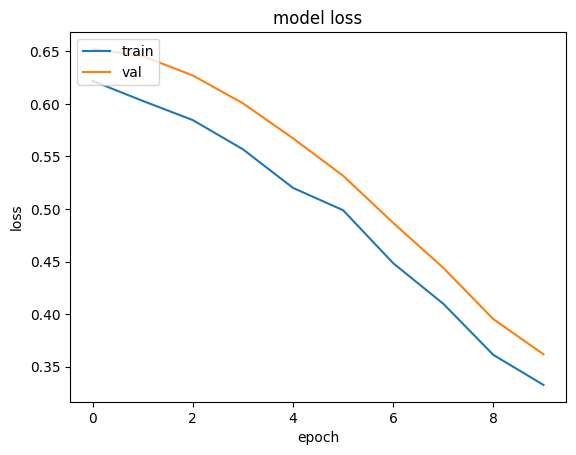

Validation accuracy: 86.00%
Predictions for green: 94 / 150
Predictions for red: 56 / 150
Points misclassified: 21
Red points misclassified: 7
Green points misclassified: 14
Average misclassification certainty: 0.68


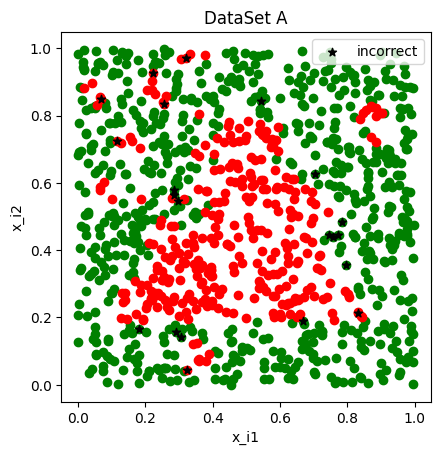

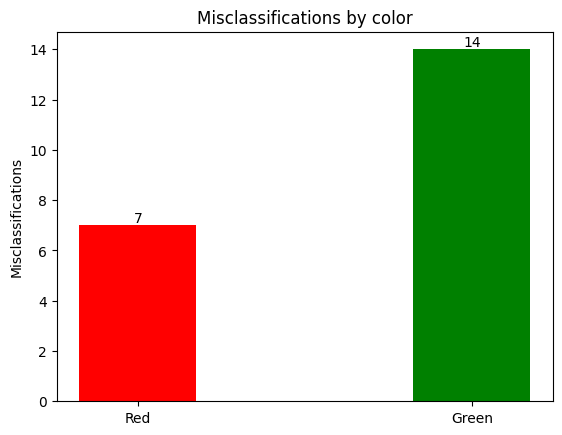

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% ETA: 0.0 minutes 

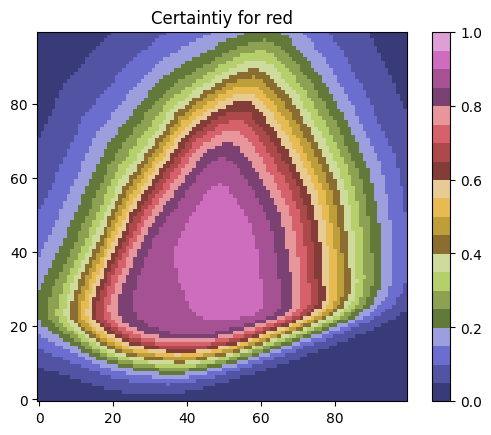

In [23]:
# Plot data
plotLoss(history)
x = showPredicitons(model_0, history, valSet_points, valSet_labels)
y = makeCertaintyMap(model_0, 100, 1)

In [ ]:
#average_penalty_effect = averagePenaltyEffect(n=15, valSet_size=8000, accuracy=20,
#                                              batch_size=768, epochs=1000) 

In [ ]:
#@title GPU and RAM info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')


 |----------------------------------------------------------------------------------------------------| 0.0% ETA: 0.0 minutes 0/57000
 |████------------------------------------------------------------------------------------------------| 4.7% ETA: 3.13 minutes 2700/57000
 |███████---------------------------------------------------------------------------------------------| 7.2% ETA: 3.4 minutes 4100/57000
 |████████--------------------------------------------------------------------------------------------| 8.8% ETA: 3.7 minutes 5000/57000
 |██████████------------------------------------------------------------------------------------------| 10.0% ETA: 3.98 minutes 5700/57000
 |███████████████████---------------------------------------------------------------------------------| 19.5% ETA: 3.07 minutes 11100/57000
 |████████████████████████----------------------------------------------------------------------------| 24.4% ETA: 2.94 minutes 13900/57000
 |███████████████████████████------

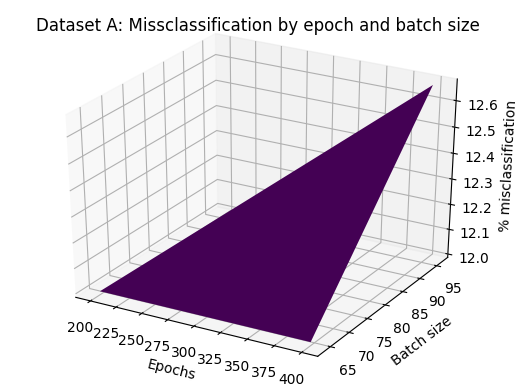

ValueError: ignored

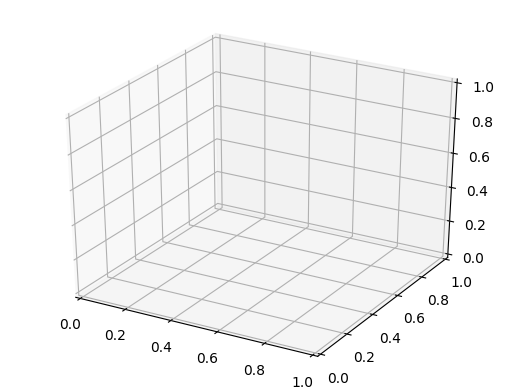

In [27]:
 epochsBatchSize = epochsBatchSize(model_0, initialWeights, 150, (32,128), 32, (100,400), 100)